# Face Recognition Pipeline for FACECOM Task_B (Colab Optimized)

## Importing the FACECOM Dataset

In [ ]:
# Face Recognition Pipeline for FACECOM Task_B (Colab Optimized)

from google.colab import drive
import os

drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:

!unzip -q "/content/drive/MyDrive/Task_B.zip" -d /content/FACECOM/


replace /content/FACECOM/Task_B/train/001_frontal/001_frontal.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Parsing Image Paths and Generating Labels

In [ ]:

import pandas as pd
import os
import glob

def extract_images_from_dir(base_dir):
    records = []
    for person in os.listdir(base_dir):
        person_path = os.path.join(base_dir, person)
        if not os.path.isdir(person_path):
            continue

        clear_images = glob.glob(os.path.join(person_path, '*.jpg'))
        distortion_folder = os.path.join(person_path, 'distortion')
        distorted_images = glob.glob(os.path.join(distortion_folder, '*.jpg')) if os.path.exists(distortion_folder) else []

        for img in clear_images + distorted_images:
            records.append({
                'image_path': img,
                'person_id': person
            })
    return pd.DataFrame(records)

train_df = extract_images_from_dir('/content/FACECOM/Task_B/train')
val_df = extract_images_from_dir('/content/FACECOM/Task_B/val')

In [ ]:

from sklearn.preprocessing import LabelEncoder

combined_df = pd.concat([train_df, val_df], ignore_index=True)
le = LabelEncoder()
combined_df['label'] = le.fit_transform(combined_df['person_id'])

#============================Change from here==============

## Image Preprocessing and Augmentation

In [ ]:

import tensorflow as tf

IMG_SIZE = 96

def load_image(img_path, label, training=True):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.efficientnet.preprocess_input(image)

    if training:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_brightness(image, 0.2)

    return image, label

## Creating TensorFlow Datasets

In [ ]:

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(combined_df, test_size=0.2, stratify=combined_df['label'], random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df['image_path'].values, train_df['label'].values)
).map(lambda x, y: load_image(x, y, training=True), num_parallel_calls=tf.data.AUTOTUNE
).shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['image_path'].values, test_df['label'].values)
).map(lambda x, y: load_image(x, y, training=False), num_parallel_calls=tf.data.AUTOTUNE
).batch(64).prefetch(tf.data.AUTOTUNE)


## Building EfficientNetB2 Model

In [ ]:

from tensorflow.keras import layers, models

def build_model():
    base = tf.keras.applications.EfficientNetB2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights='imagenet', include_top=False
    )
    base.trainable = True

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(len(le.classes_), activation='softmax')(x)  # Change here
    return models.Model(inputs, outputs)


## Compiling the Model with Distribution Strategy

In [ ]:

strategy = tf.distribute.get_strategy()
print("✅ Running with strategy:", strategy)

with strategy.scope():
    model = build_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Change here


✅ Running with strategy: <tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x792a02db0f90>


## Training the Model with Callbacks

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint('/content/best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=15,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/15

Epoch 1: val_loss improved from inf to 5.56320, saving model to /content/best_model.keras
235/235 - 255s - 1s/step - accuracy: 0.0847 - loss: 6.4080 - val_accuracy: 0.1453 - val_loss: 5.5632
Epoch 2/15

Epoch 2: val_loss improved from 5.56320 to 4.33645, saving model to /content/best_model.keras
235/235 - 56s - 239ms/step - accuracy: 0.1914 - loss: 5.0519 - val_accuracy: 0.2720 - val_loss: 4.3364
Epoch 3/15

Epoch 3: val_loss improved from 4.33645 to 3.03940, saving model to /content/best_model.keras
235/235 - 57s - 241ms/step - accuracy: 0.3432 - loss: 3.8007 - val_accuracy: 0.5012 - val_loss: 3.0394
Epoch 4/15

Epoch 4: val_loss improved from 3.03940 to 1.81804, saving model to /content/best_model.keras
235/235 - 57s - 241ms/step - accuracy: 0.5900 - loss: 2.5502 - val_accuracy: 0.7764 - val_loss: 1.8180
Epoch 5/15

Epoch 5: val_loss improved from 1.81804 to 0.92944, saving model to /content/best_model.keras
235/235 - 82s - 348ms/step - accuracy: 0.8086 - loss: 1.5018 - v

## Evaluating Model Accuracy and F1 Score

In [ ]:

from sklearn.metrics import accuracy_score, f1_score
import numpy as np

pred_probs = model.predict(test_dataset, verbose=0)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = test_df['label'].values

acc = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='macro')
print(f"Top-1 Accuracy: {acc:.4f}")
print(f"Macro F1 Score: {f1:.4f}")

Top-1 Accuracy: 0.9931
Macro F1 Score: 0.9943


## Saving and Exporting Trained Model


In [ ]:

model.save('/content/facerecognition_efficientnet.keras')


In [ ]:

!zip -r /content/face_model.zip /content/facerecognition_efficientnet.keras
!cp /content/face_model.zip "/content/drive/MyDrive/"

  adding: content/facerecognition_efficientnet.keras (deflated 9%)


## Visualizing Misclassified Faces

Showing 10 misclassified faces:


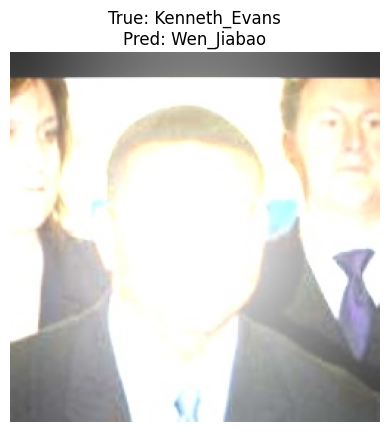

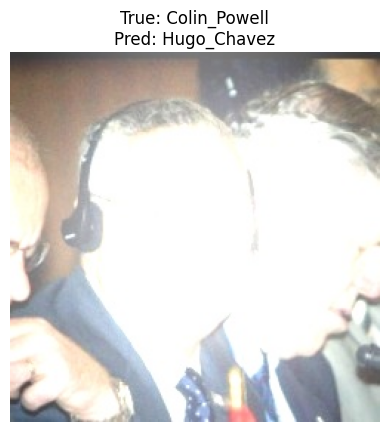

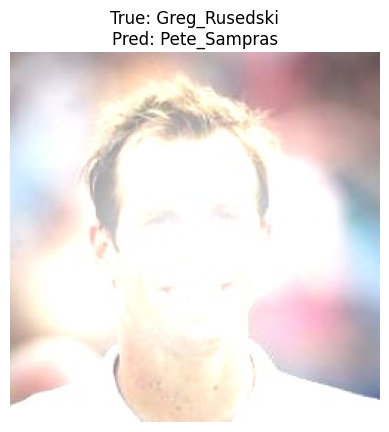

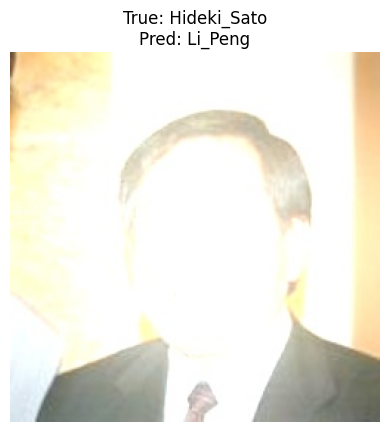

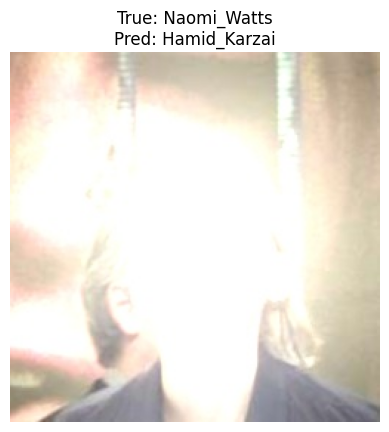

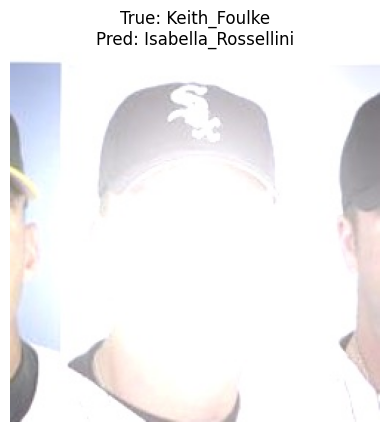

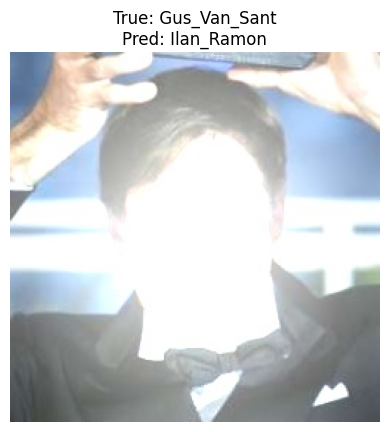

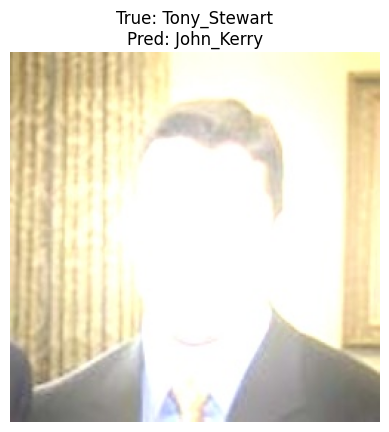

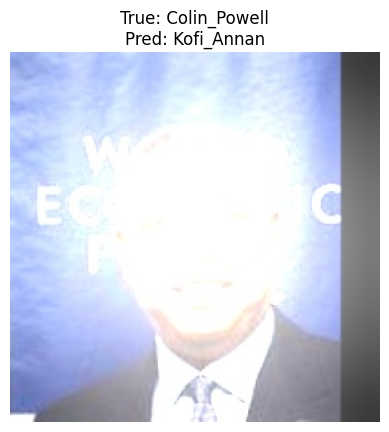

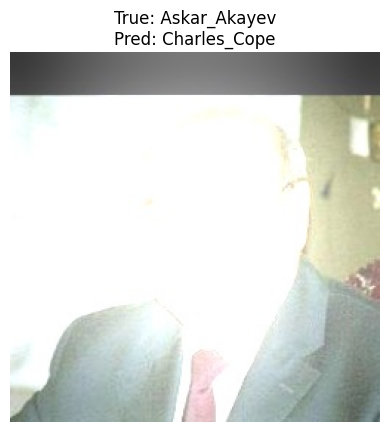

In [ ]:

import matplotlib.pyplot as plt

mis_idx = np.where(pred_labels != true_labels)[0]
if len(mis_idx) > 0:
    print(f"Showing {min(10, len(mis_idx))} misclassified faces:")
    for i in range(min(10, len(mis_idx))):
        idx = mis_idx[i]
        img_path = test_df.iloc[idx]['image_path']
        img = tf.keras.utils.load_img(img_path)
        plt.imshow(img)
        plt.title(f"True: {le.inverse_transform([true_labels[idx]])[0]}\nPred: {le.inverse_transform([pred_labels[idx]])[0]}")
        plt.axis('off')
        plt.show()
else:
    print("🎉 No misclassified samples!")